# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

In [1]:
#First of all we remove the outliers
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def pre_processing(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt



# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.


# Get all the folders in the base_dictionary
path_list = [f for f in path_list if not f.endswith('.xlsx')]
# Only keep the folders, not the excel file.

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')




In [3]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

Model for motor 6:


/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 8.626677004715916
training performance, mean root square error is: 1.8314723398377528
training performance, residual error > 1: 54.15860735009671%

 New run:

testing performance, max error is: 14.209864360212613
testing performance, mean root square error is: 6.503248647233358
testing performance, residual error > 1: 81.8774844562226%


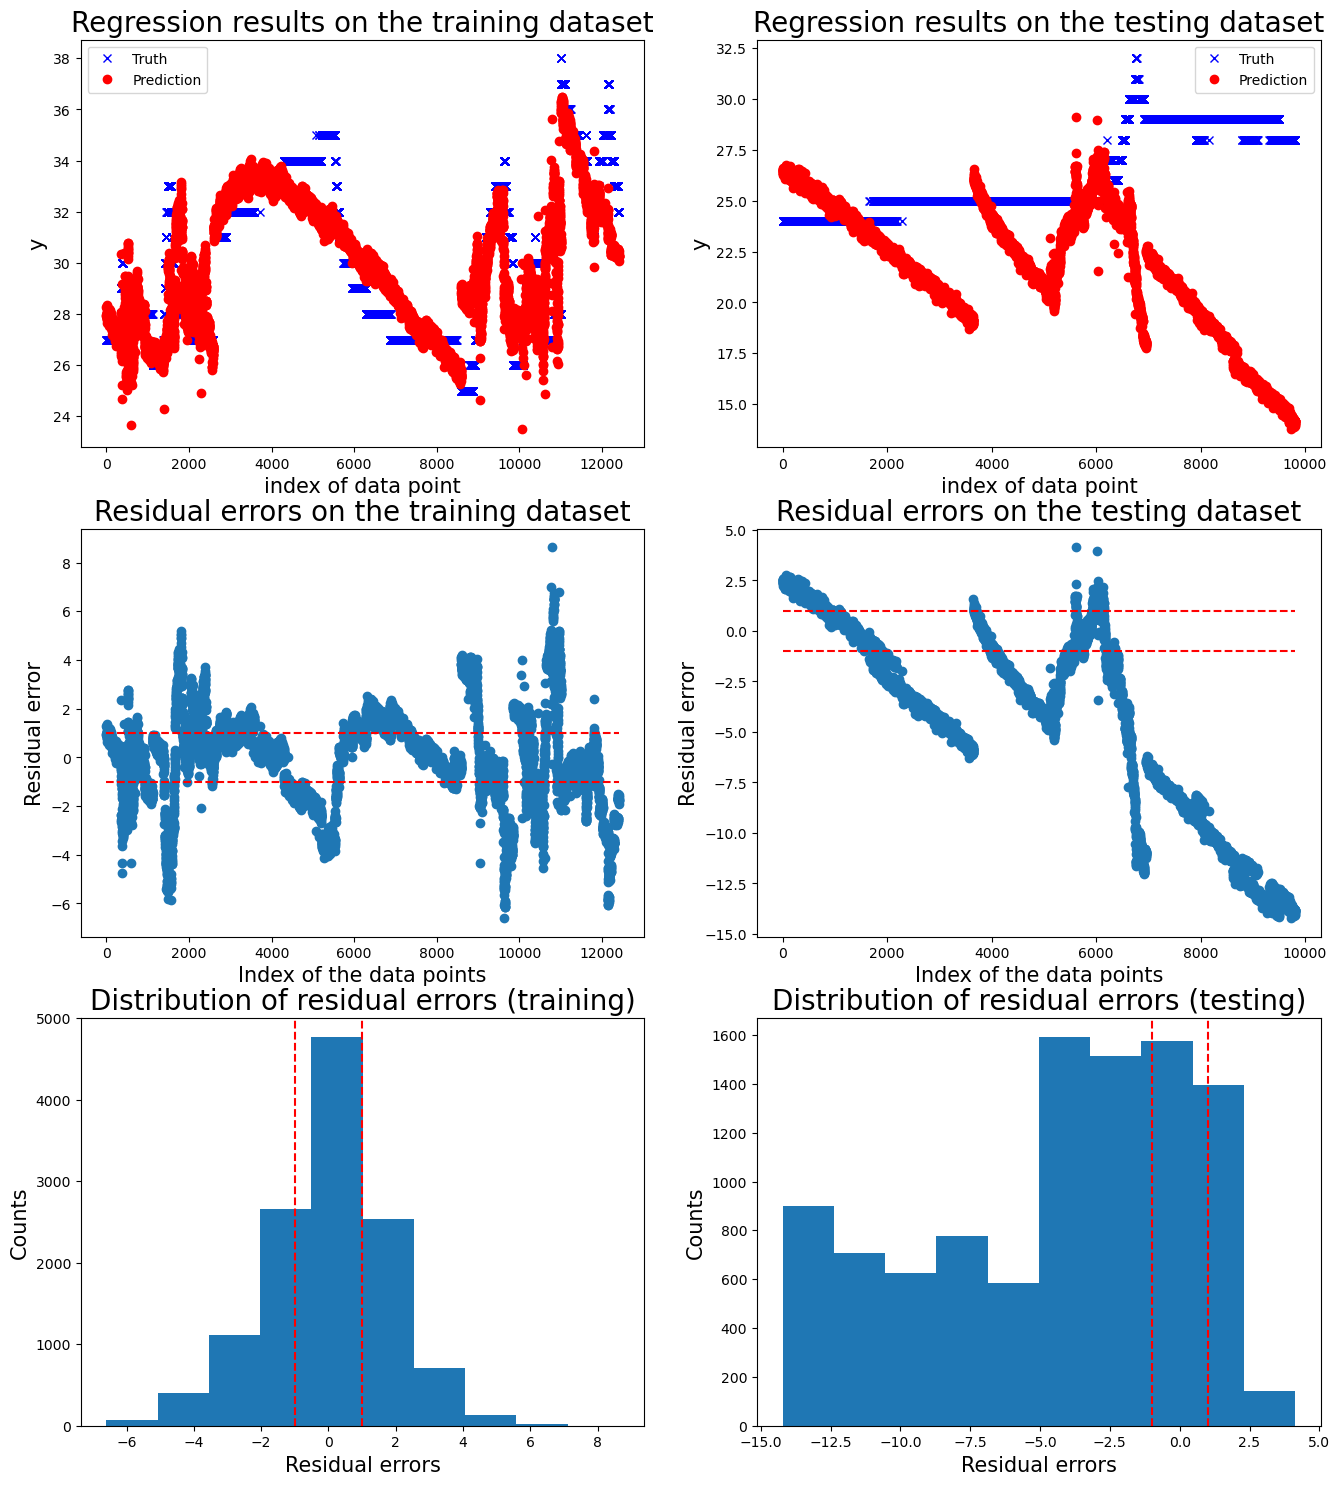

/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 9.458808087158666
training performance, mean root square error is: 1.8481465739226082
training performance, residual error > 1: 64.2623572342543%

 New run:

testing performance, max error is: 14.916204534630113
testing performance, mean root square error is: 5.523604893885907
testing performance, residual error > 1: 99.55277280858677%


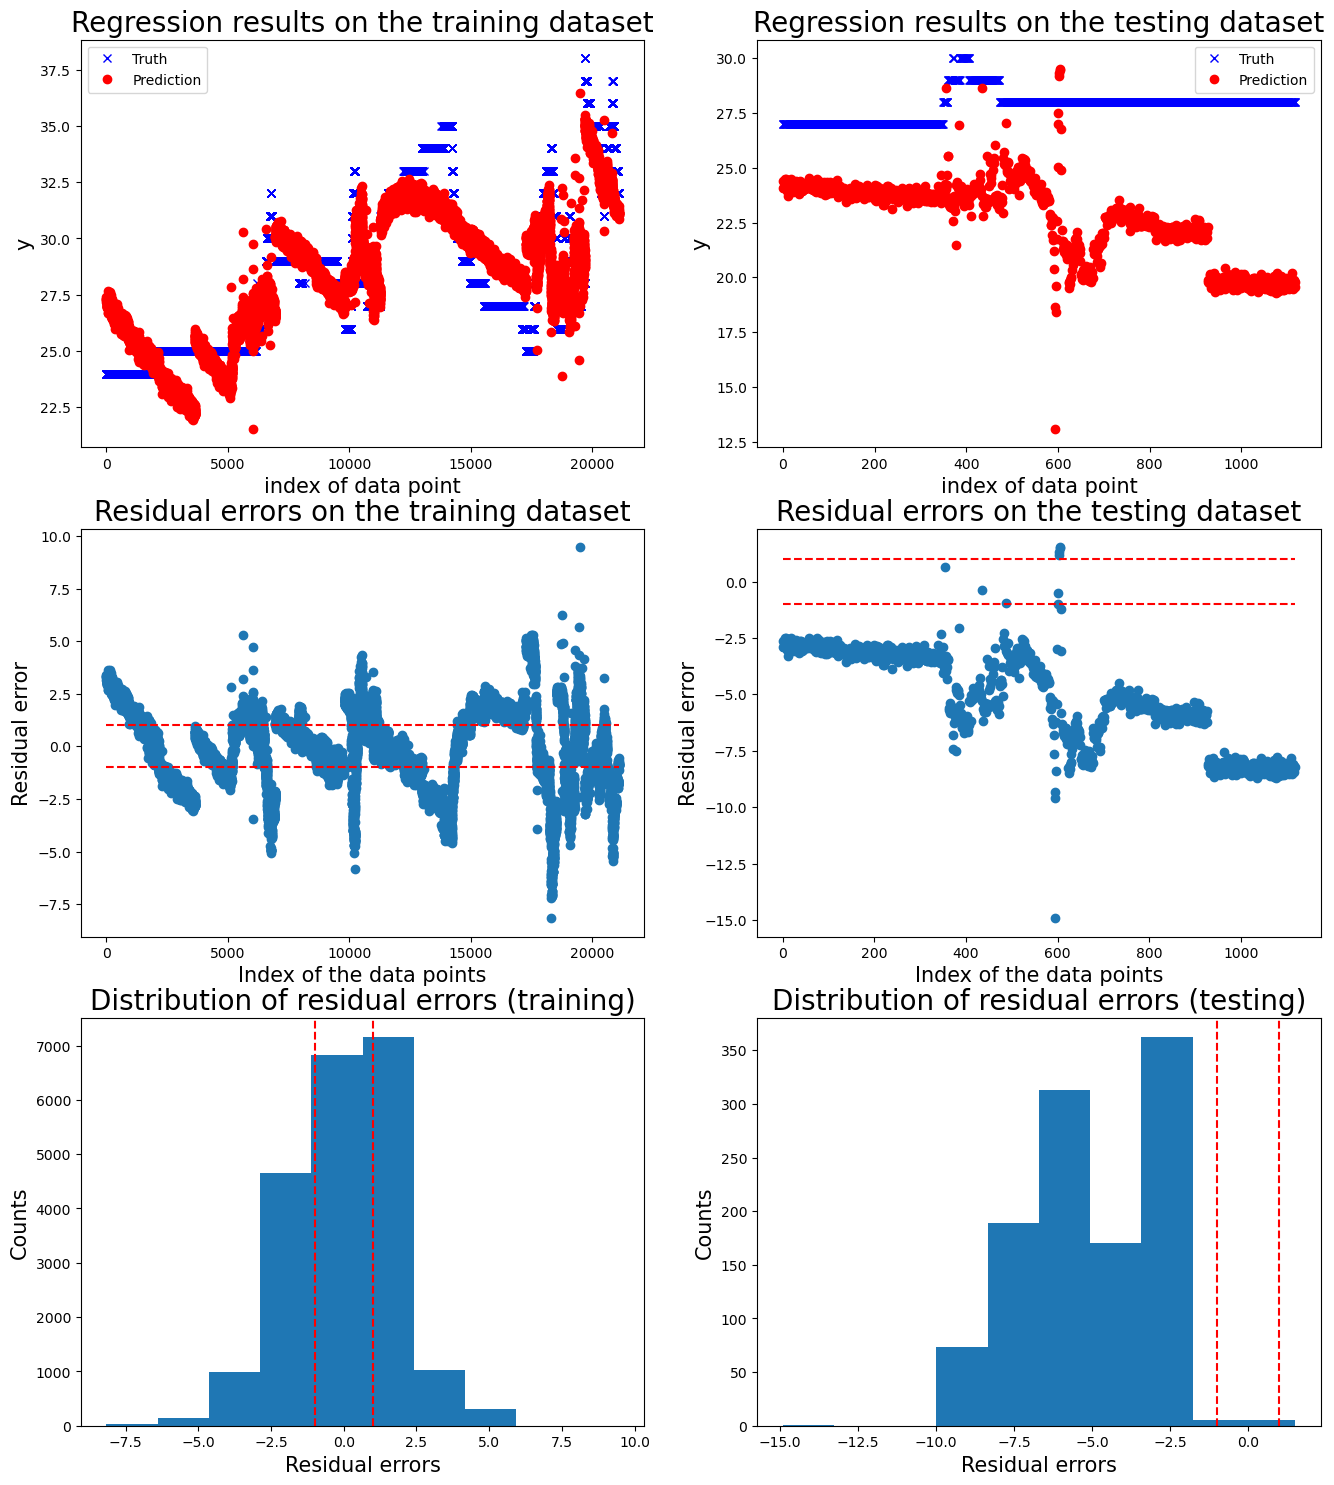

/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 7.17983812598893
training performance, mean root square error is: 1.3962605079065813
training performance, residual error > 1: 27.643482129615897%

 New run:

testing performance, max error is: 8.129535141505045
testing performance, mean root square error is: 4.227287775794871
testing performance, residual error > 1: 63.23142104660483%


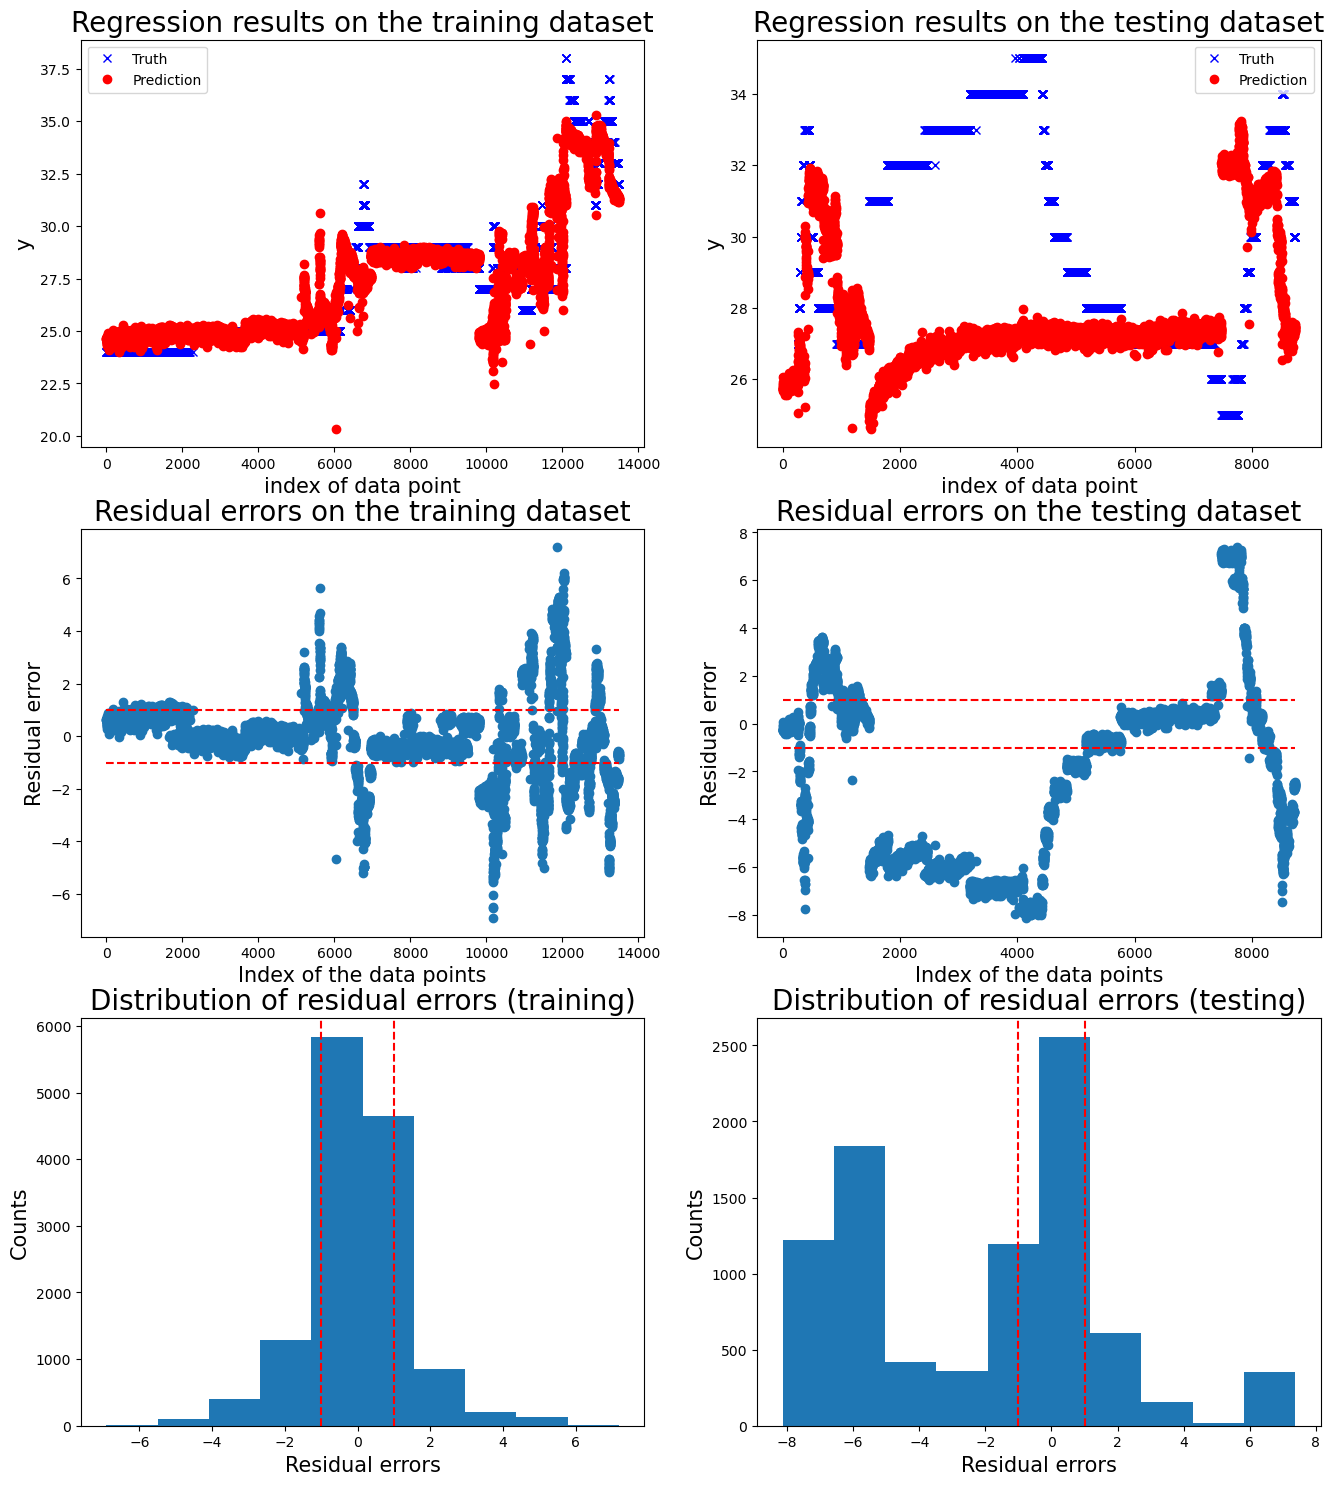

/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 10.231472761353103
training performance, mean root square error is: 1.821861814828333
training performance, residual error > 1: 63.29208498715854%

 New run:

testing performance, max error is: 11.186460812677367
testing performance, mean root square error is: 5.163097546803082
testing performance, residual error > 1: 83.83084577114428%


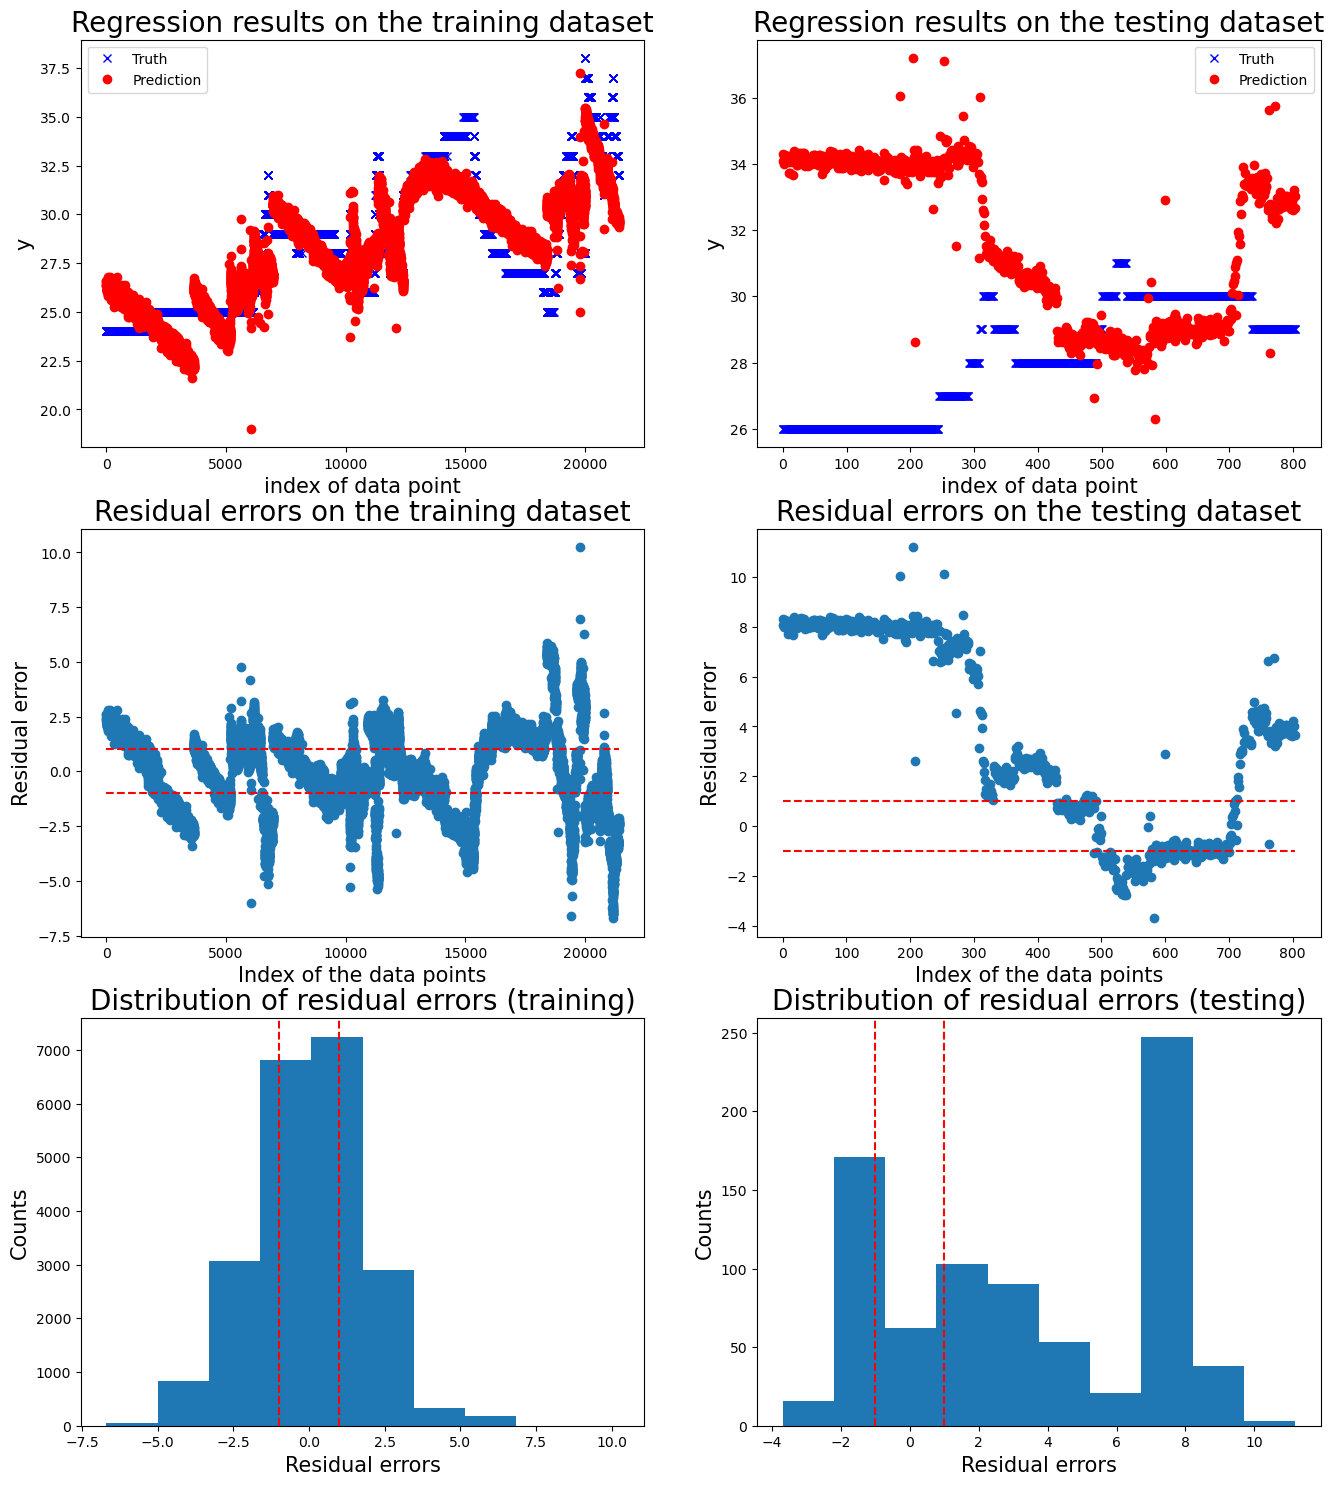

/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

training performance, max error is: 8.434280587100577
training performance, mean root square error is: 1.7891514892411866
training performance, residual error > 1: 60.124108277142575%

 New run:

testing performance, max error is: 9.631485791126984
testing performance, mean root square error is: 5.175136783894336
testing performance, residual error > 1: 87.73531089560753%


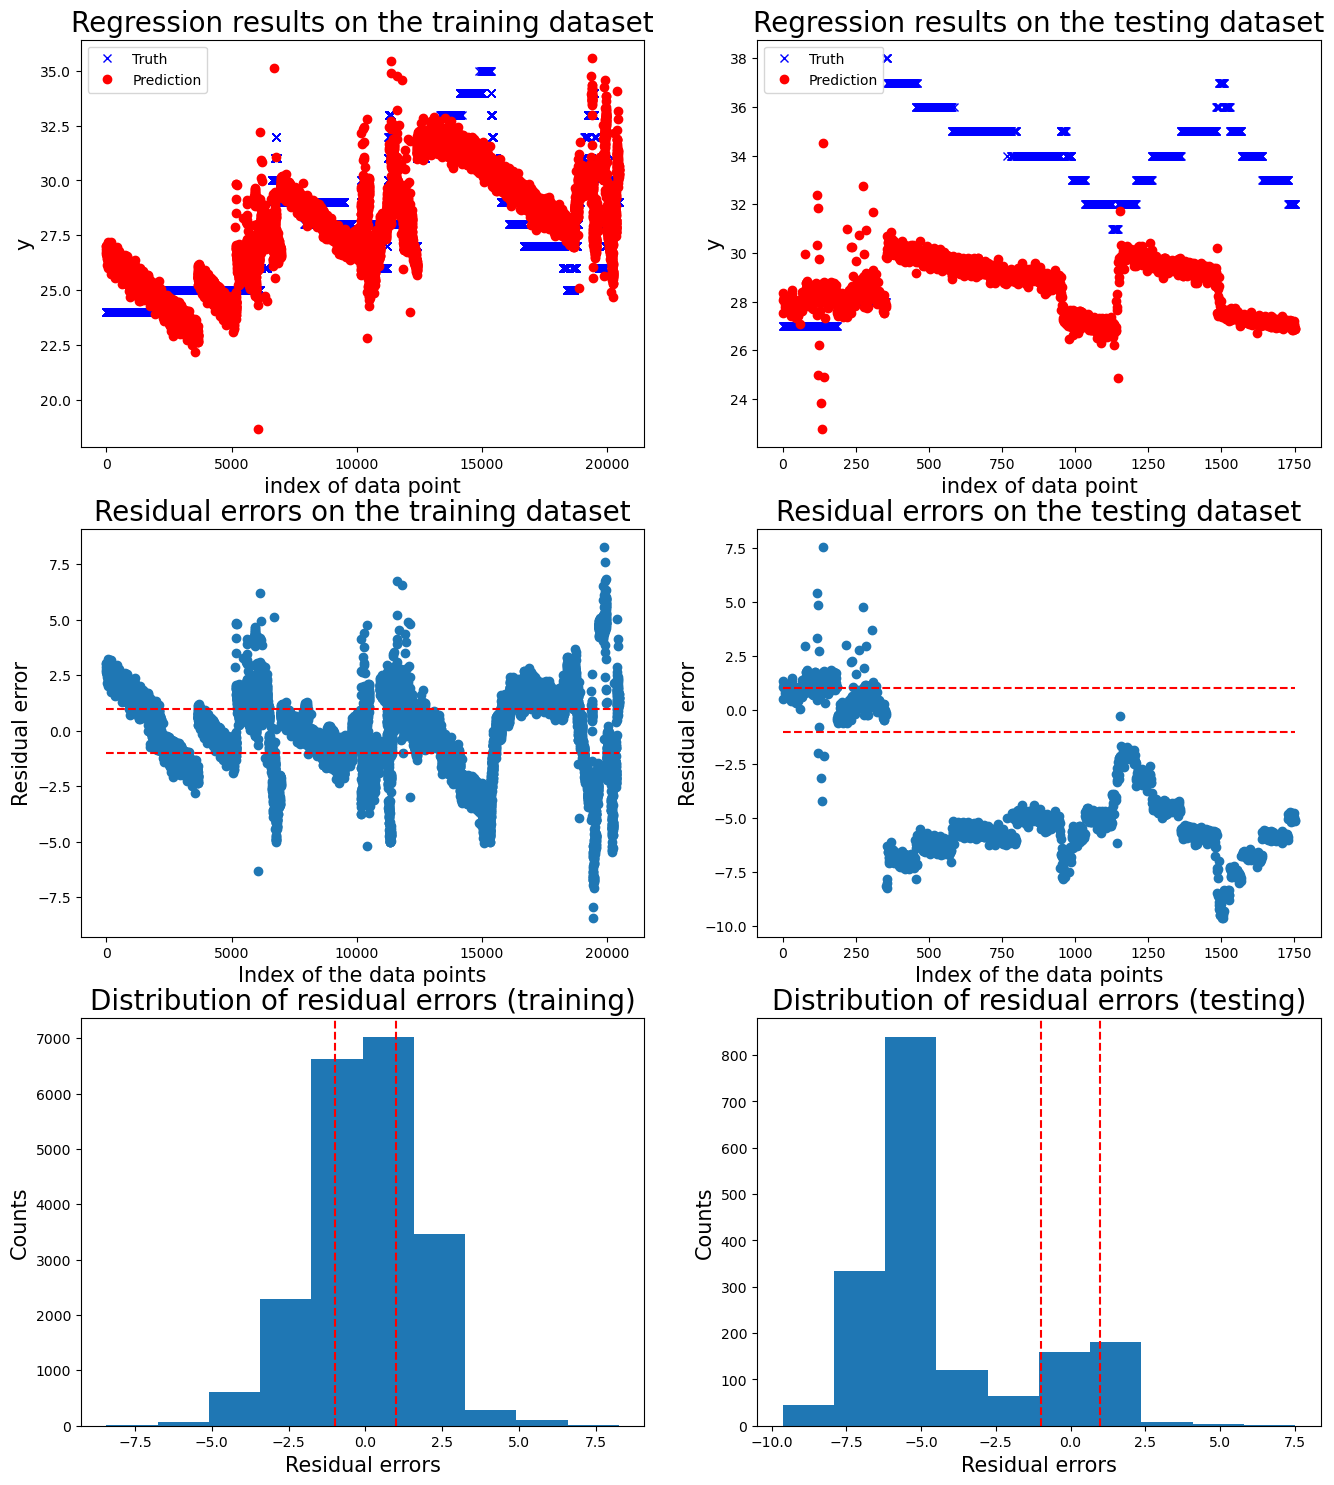

   Max error      RMSE  Exceed boundary rate
0  14.209864  6.503249              0.818775
1  14.916205  5.523605              0.995528
2   8.129535  4.227288              0.632314
3  11.186461  5.163098              0.838308
4   9.631486  5.175137              0.877353


Mean performance metric and standard error:
Max error: 11.6147 +- 2.9111
RMSE: 5.3185 +- 0.8187
Exceed boundary rate: 0.8325 +- 0.1312




In [5]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   10.2%  |   1.83%   |  63.3% | 
| Model 2 |   8.12%  |   4.23%   |  63.2% | 
| Model 3 |   9.45%  |   1.84%   |  64.3% | 

With our models we could minimize the mean root square of the error. But the high value of residual error shows us, that the models if they only use the data at the moment do not perform that well. We should train our model with more data, and try out some other regression models.

We used for pre processing standardization and removed the outliers, we used the steosize of 1, for the calculations.

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [8]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, max_error, root_mean_squared_error
from utility import read_all_test_data_from_path

def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]

    return df

# Define the sliding window function
def prepare_sliding_window(df, window_size, feature_list):
    df_windowed = []
    for i in range(window_size, len(df)):
        window_data = df[feature_list].iloc[i-window_size:i].values.flatten()
        df_windowed.append(window_data)
    df_windowed = pd.DataFrame(df_windowed)
    return df_windowed

# Define parameters for the sliding window
window_size = 5
feature_list_all = [
    'time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage'
]

# Read and preprocess the data
base_dictionary = '../../../dataset/training_data/'  # Ensure this path is correct relative to your script location
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)
df_data_smoothing = df_data.copy()  # Apply smoothing here if necessary

# Prepare sliding window data
df_data_windowed = prepare_sliding_window(df_data, window_size, feature_list_all)
df_data_smoothing_windowed = prepare_sliding_window(df_data_smoothing, window_size, feature_list_all)

# Prepare target variable (adjusted for the sliding window)
target_column = 'data_motor_6_temperature'
y = df_data[target_column][window_size:].reset_index(drop=True)

# Define the cross-validation scheme
kf = KFold(n_splits=5)

# Initialize lists to store performance metrics
max_errors = []
rmses = []
out_of_boundary_rates = []

# Perform cross-validation
for train_index, test_index in kf.split(df_data_windowed):
    X_train, X_test = df_data_windowed.iloc[train_index], df_data_windowed.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create the pipeline
    mdl_linear_regreession = Pipeline([
        ('standardizer', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Train the model
    mdl_linear_regreession.fit(X_train, y_train)
    
    # Make predictions
    y_pred = mdl_linear_regreession.predict(X_test)
    
    # Calculate performance metrics
    max_errors.append(max_error(y_test, y_pred))
    rmses.append(root_mean_squared_error(y_test, y_pred))
    out_of_boundary_rate = sum(abs(y_test - y_pred) > 3) / len(y_test)
    out_of_boundary_rates.append(out_of_boundary_rate)

# Calculate mean performance metrics
mean_max_error = np.mean(max_errors)
mean_rmse = np.mean(rmses)
mean_out_of_boundary_rate = np.mean(out_of_boundary_rates)

# Print results
print(f'Max Error: {mean_max_error:.4f}')
print(f'RMSE: {mean_rmse:.4f}')
print(f'Out of Boundary Rate: {mean_out_of_boundary_rate:.4f}')

Max Error: 3.9989
RMSE: 0.1566
Out of Boundary Rate: 0.0002


**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   3.99%  |   0.15%   |  0.002% | 
 
Window size=5; sample step=5

 If our model is able to use the data from the past the model performs much better. But we might be able to use bigger window size to further improve efficiency.

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

Model for motor 6:


100%|██████████| 1/1 [00:09<00:00,  9.18s/it]



 New run:

testing performance, max error is: 3.66
testing performance, mean root square error is: 0.6152392205554759
testing performance, residual error > 1.499663332489599: 5.780520849014%

 New run:

testing performance, accuracy is: 0.9513773897335541
testing performance, precision is: 0.8775510204081632
testing performance, recall: 0.555735056542811
testing performance, F1: 0.6805143422354105




/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


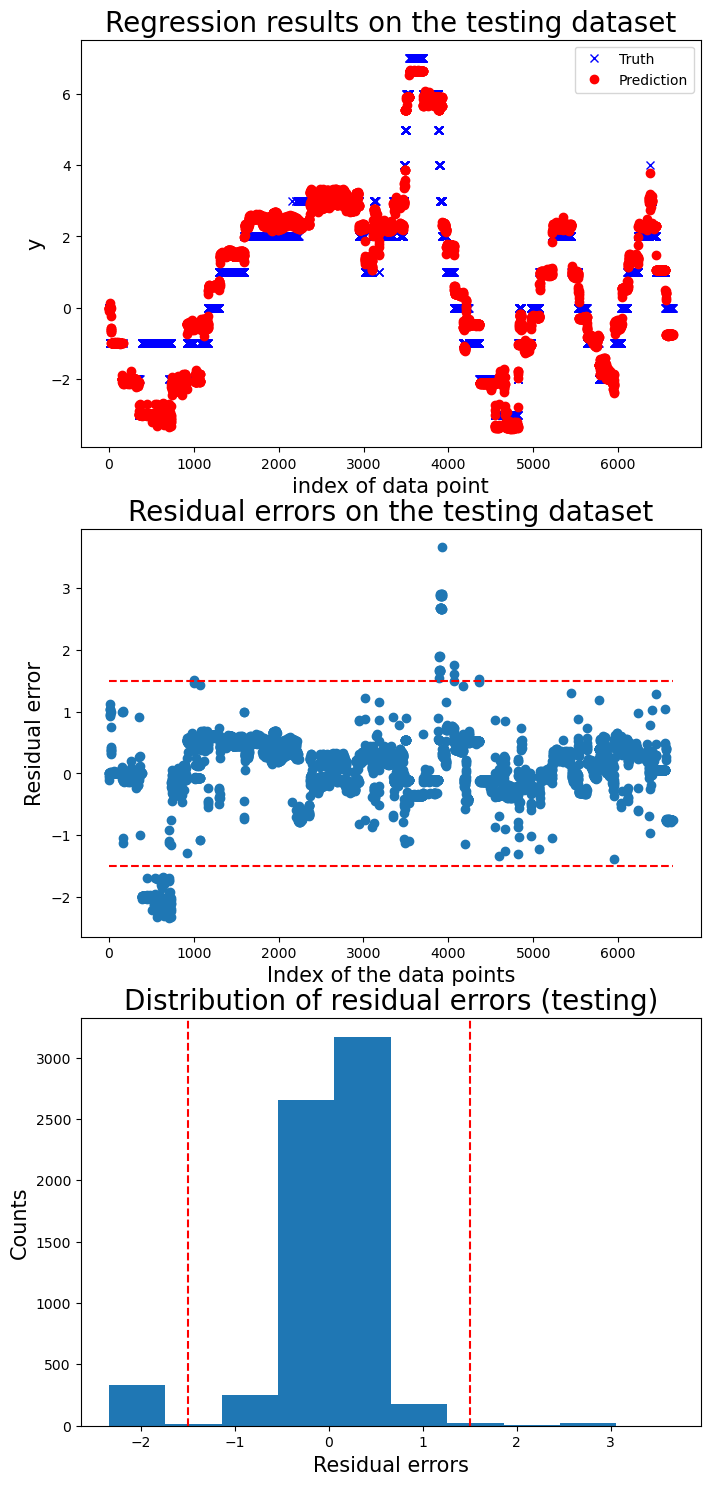

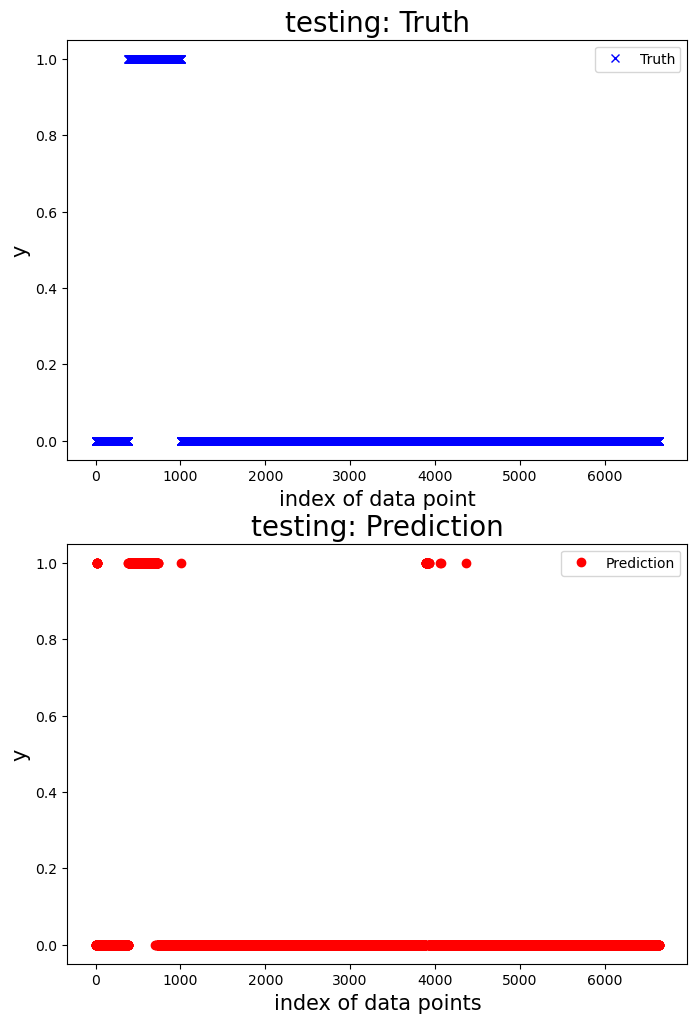

100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 4.0
testing performance, mean root square error is: 1.1867876241623287
testing performance, residual error > 0.9: 27.927927927927925%

 New run:

testing performance, accuracy is: 0.9099099099099099
testing performance, precision is: 1.0
testing performance, recall: 0.7560975609756098
testing performance, F1: 0.8611111111111112




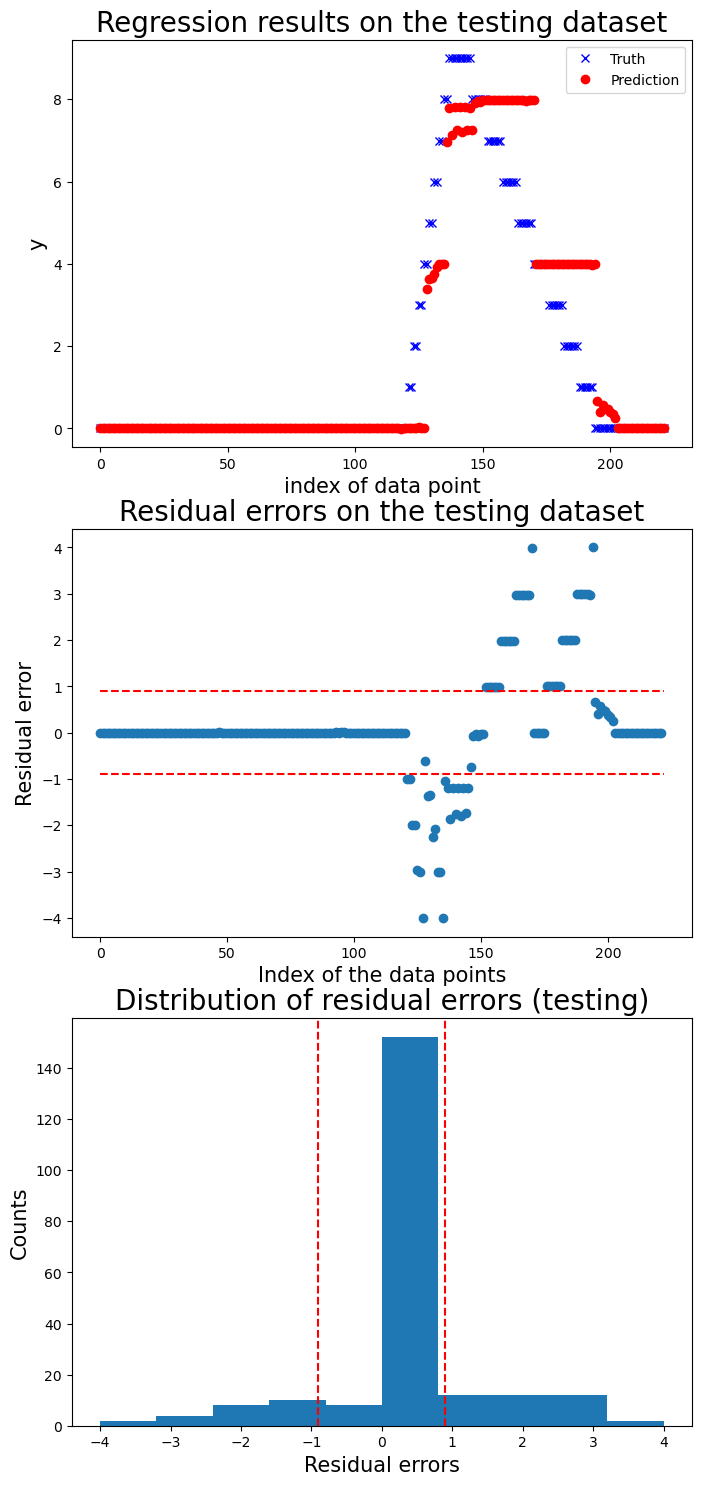

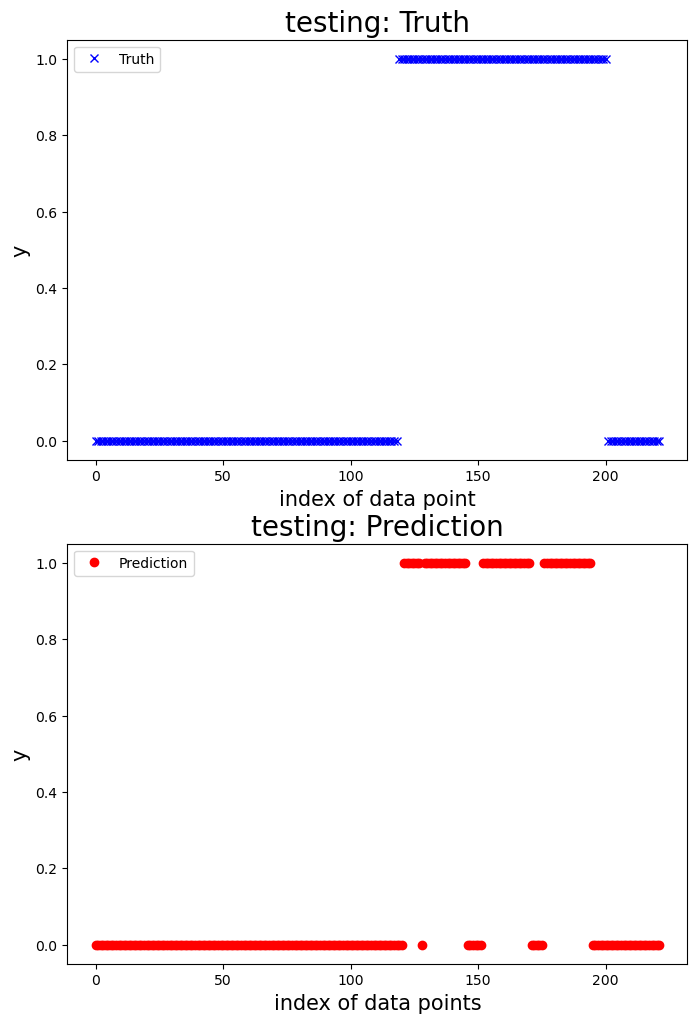

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 3.0
testing performance, mean root square error is: 0.7476210303901767
testing performance, residual error > 0.9: 16.152450090744104%

 New run:

testing performance, accuracy is: 0.9274047186932849
testing performance, precision is: 1.0
testing performance, recall: 0.689922480620155
testing performance, F1: 0.8165137614678899




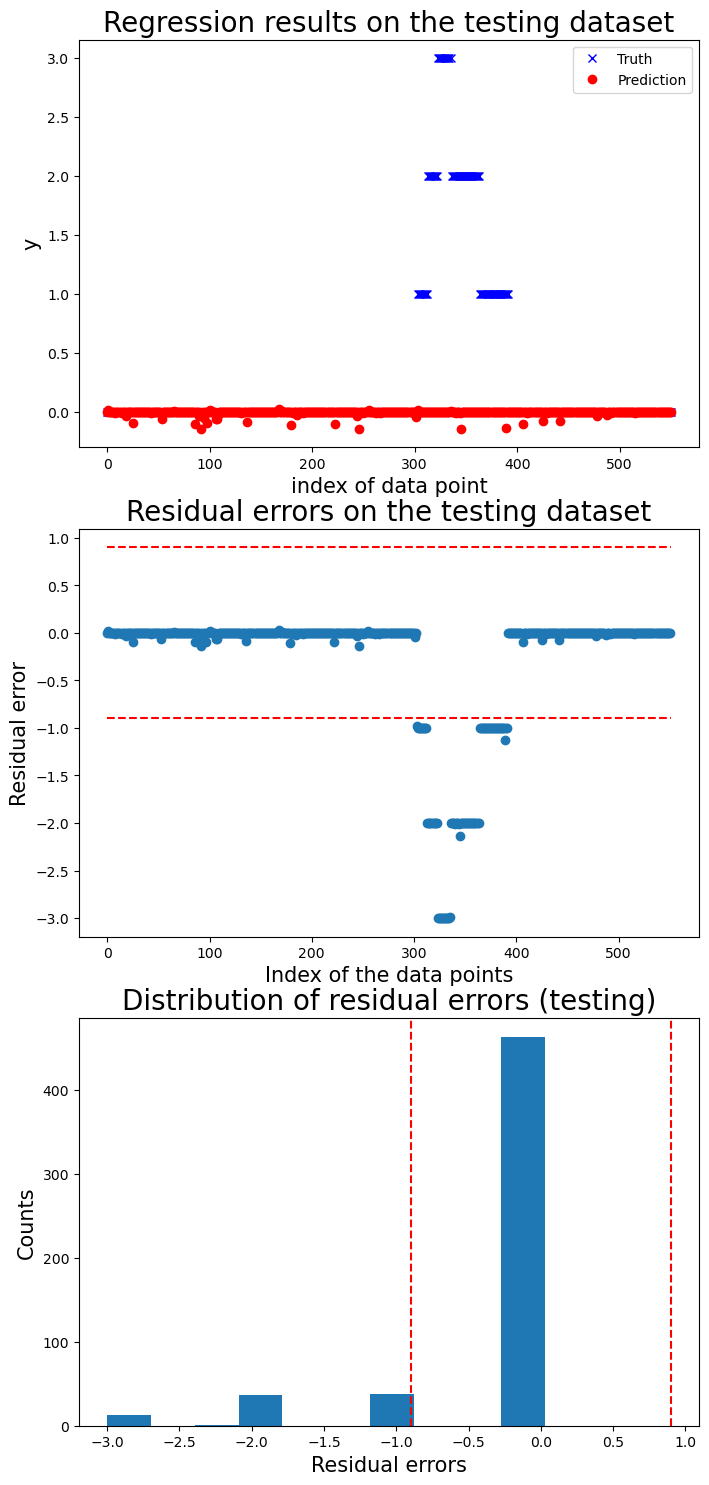

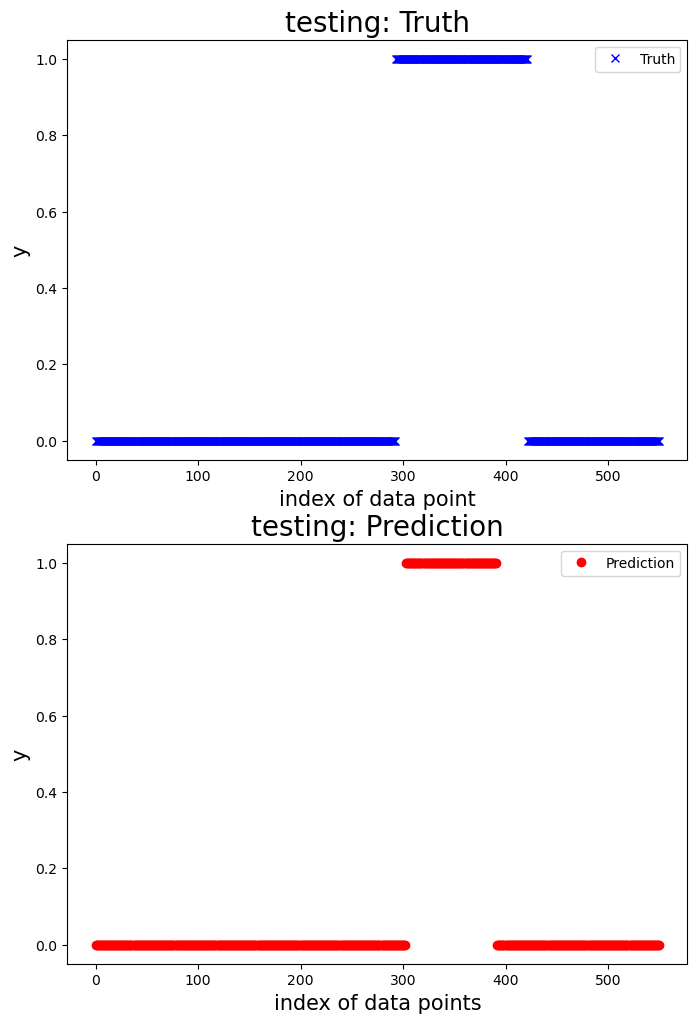

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



 New run:

testing performance, max error is: 2.0
testing performance, mean root square error is: 0.24099551983327436
testing performance, residual error > 0.9: 3.3816425120772946%

 New run:

testing performance, accuracy is: 0.9729468599033816
testing performance, precision is: 1.0
testing performance, recall: 0.5555555555555556
testing performance, F1: 0.7142857142857143




/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


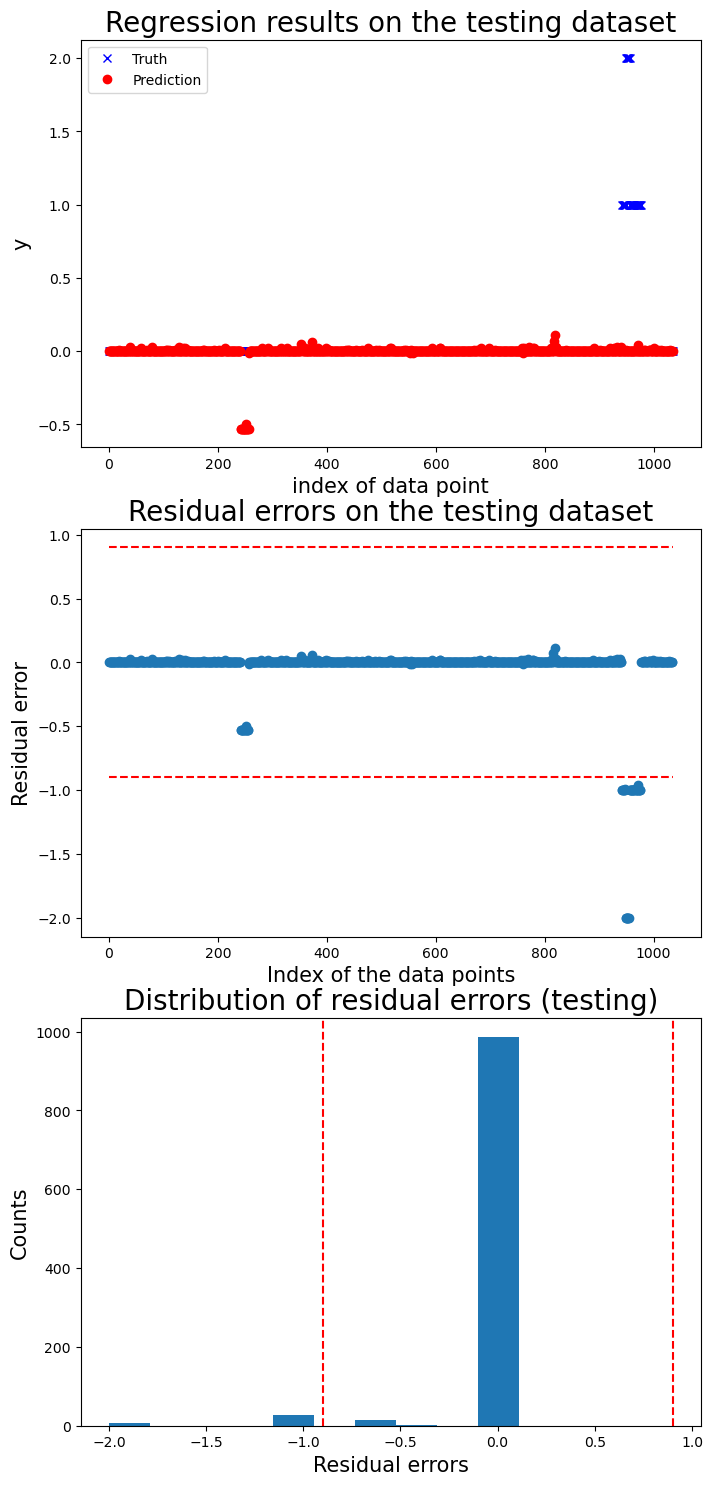

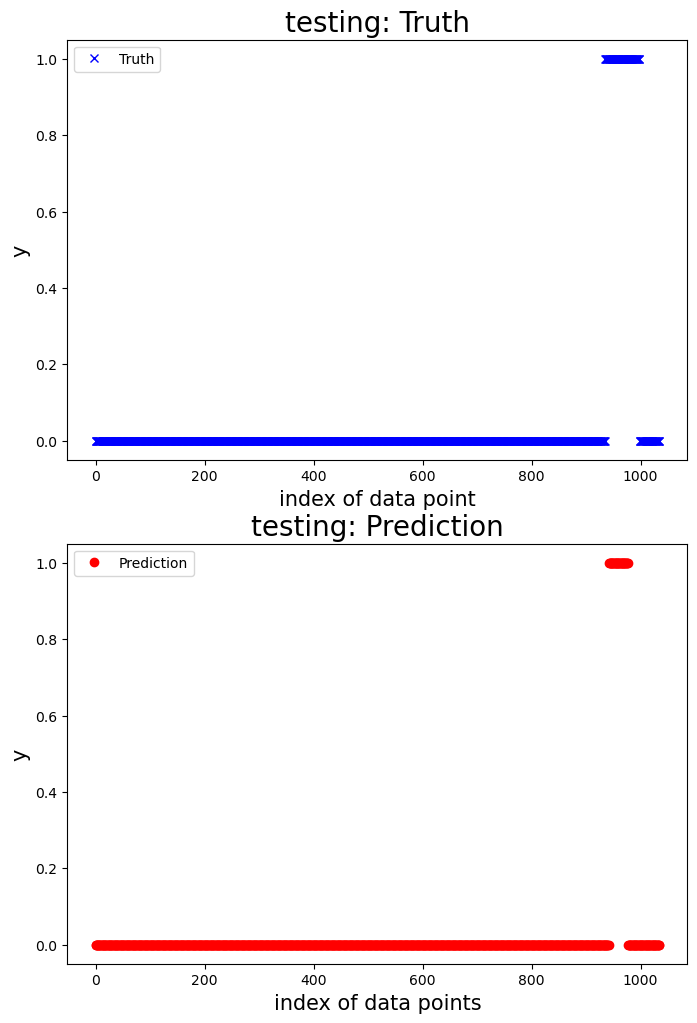

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]



 New run:

testing performance, max error is: 4.0
testing performance, mean root square error is: 1.2343527673991601
testing performance, residual error > 0.9: 71.05263157894737%

 New run:

testing performance, accuracy is: 0.42719298245614035
testing performance, precision is: 0.3111111111111111
testing performance, recall: 0.7262247838616714
testing performance, F1: 0.43560933448573896




/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


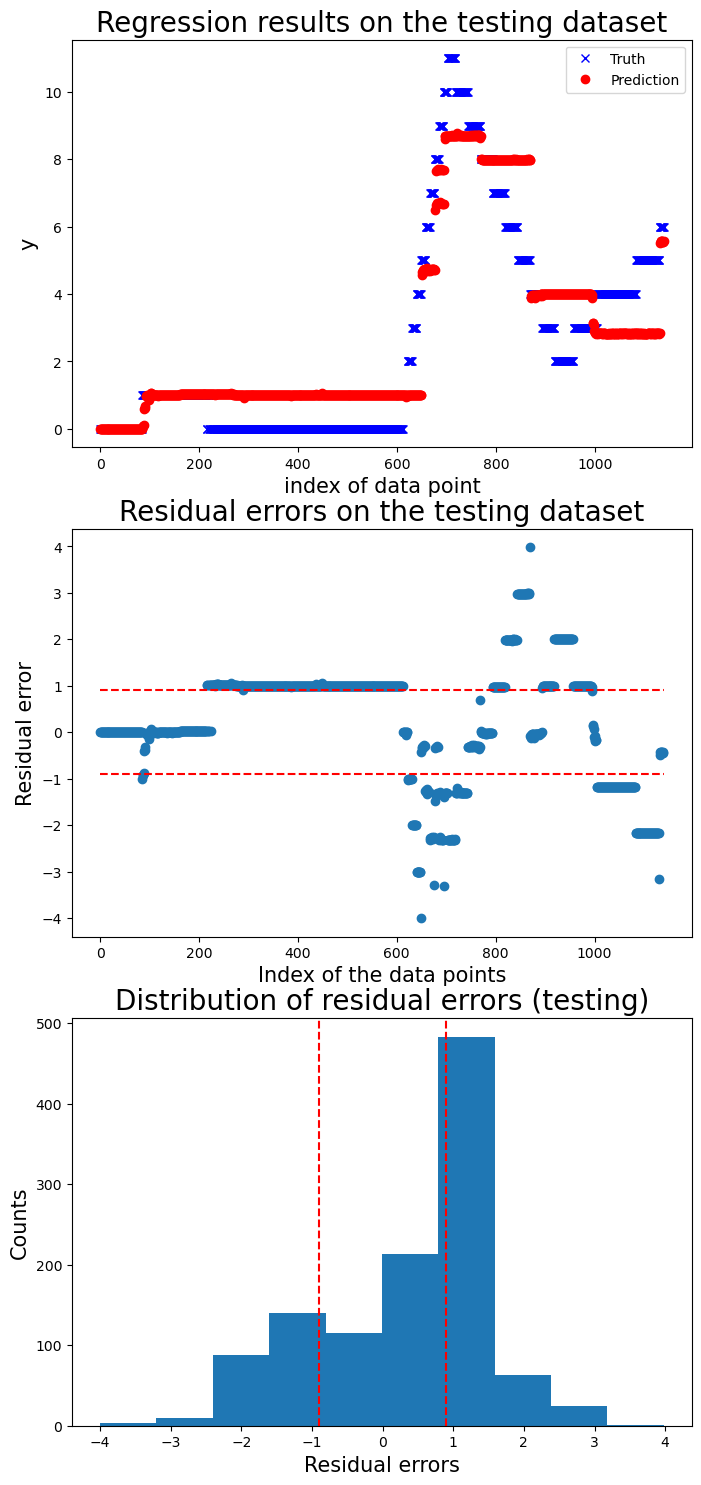

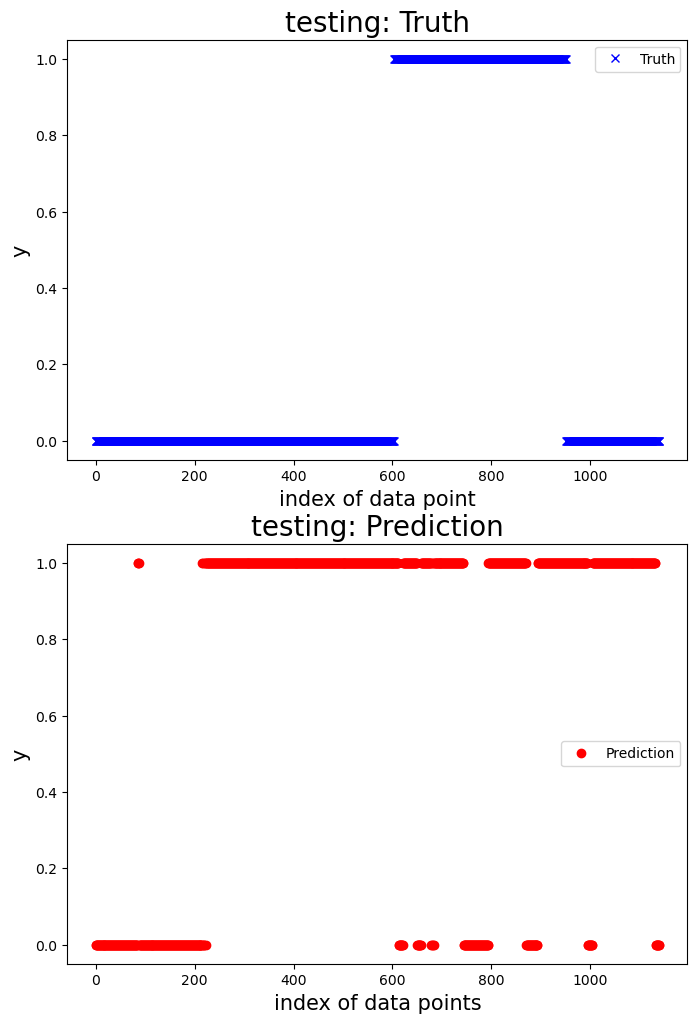

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 New run:

testing performance, max error is: 6.210000000000001
testing performance, mean root square error is: 2.5695846462487455
testing performance, residual error > 0.9: 69.32203389830508%

 New run:

testing performance, accuracy is: 0.8152542372881356
testing performance, precision is: 0.9535452322738386
testing performance, recall: 0.8125
testing performance, F1: 0.8773903262092239




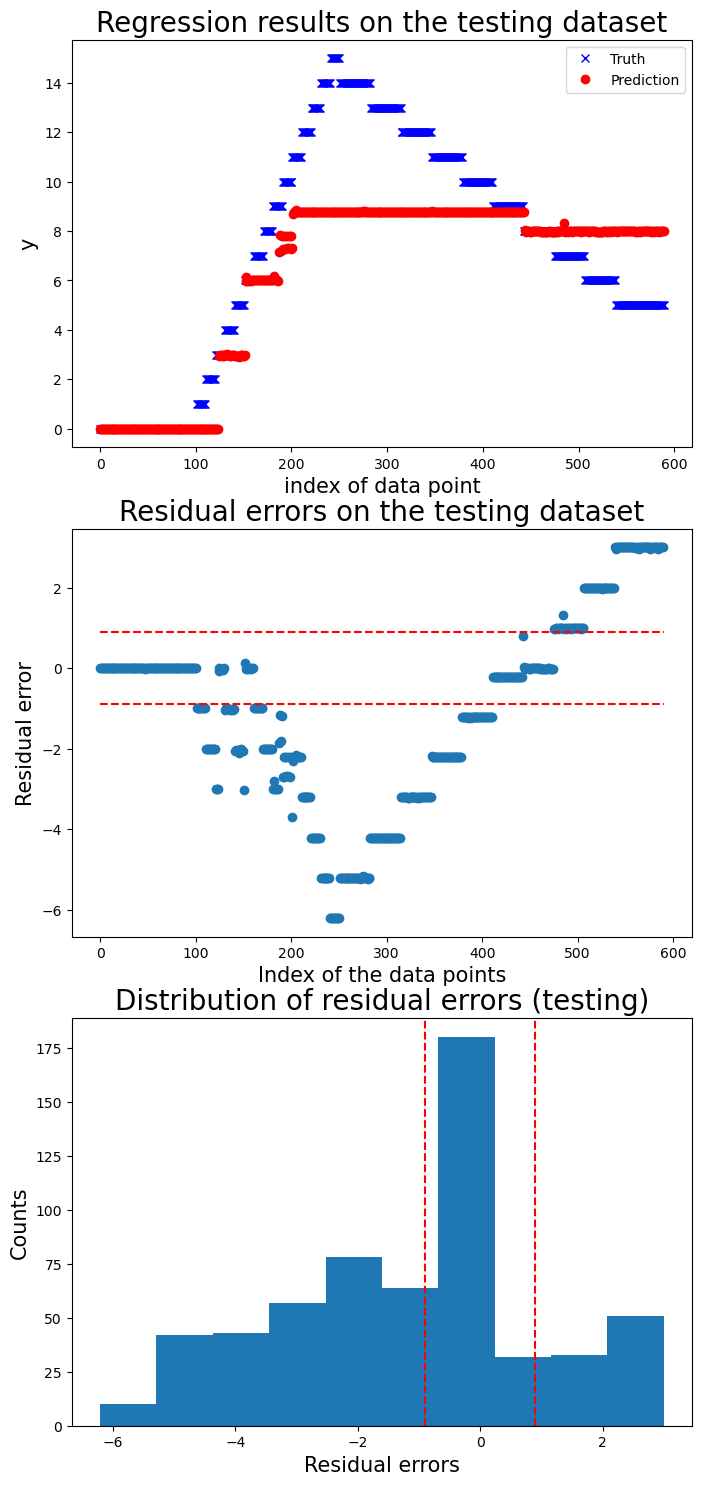

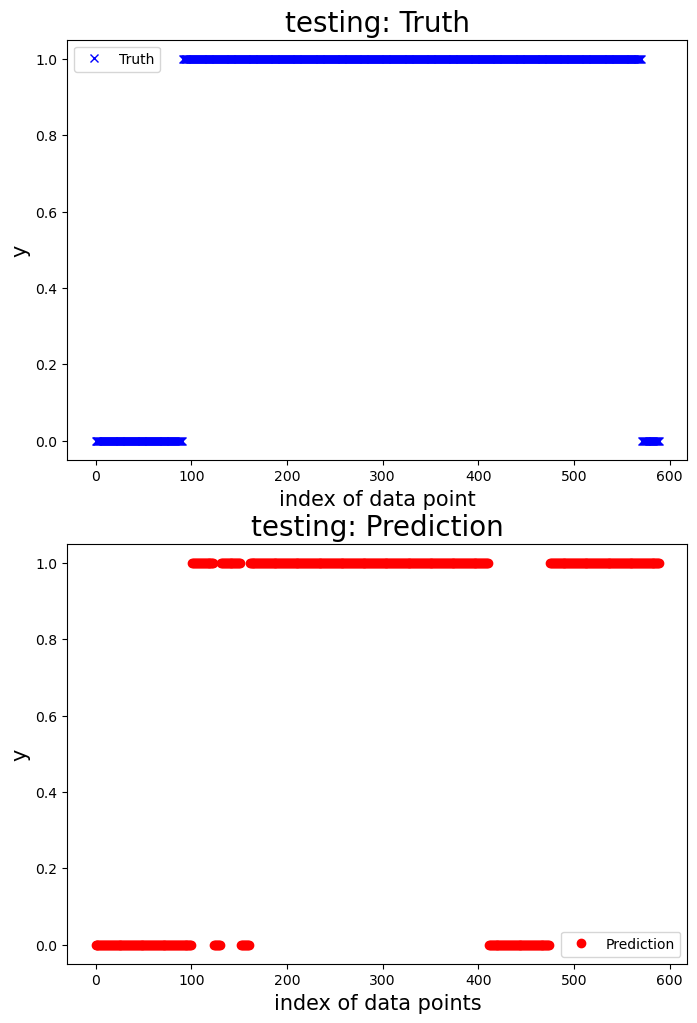

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]



 New run:

testing performance, max error is: 3.56
testing performance, mean root square error is: 0.9934118266316677
testing performance, residual error > 1.493365775553142: 14.713541666666666%

 New run:

testing performance, accuracy is: 0.6927083333333334
testing performance, precision is: 0.4482758620689655
testing performance, recall: 0.49056603773584906
testing performance, F1: 0.46846846846846846




/Users/juanibaserga/Documents/GitHub/digital_twin_robot/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


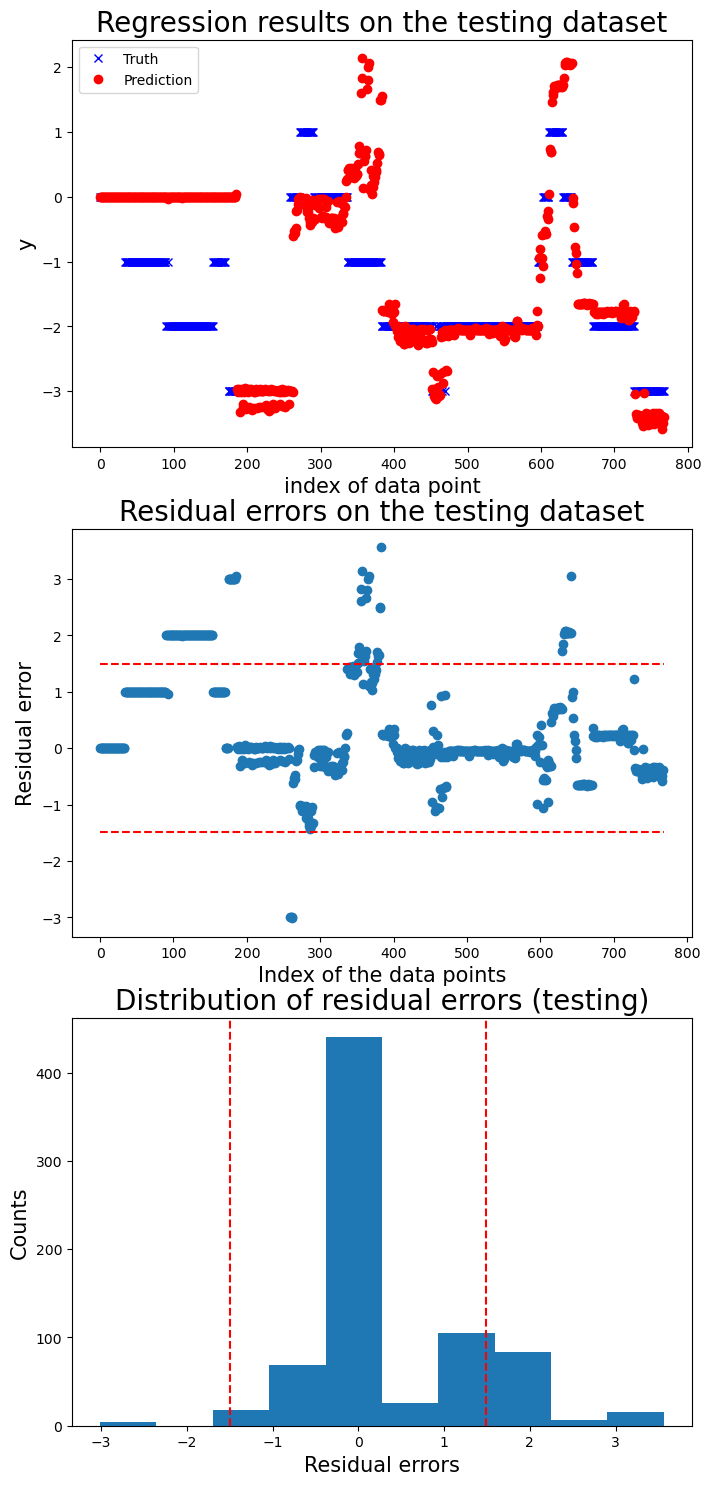

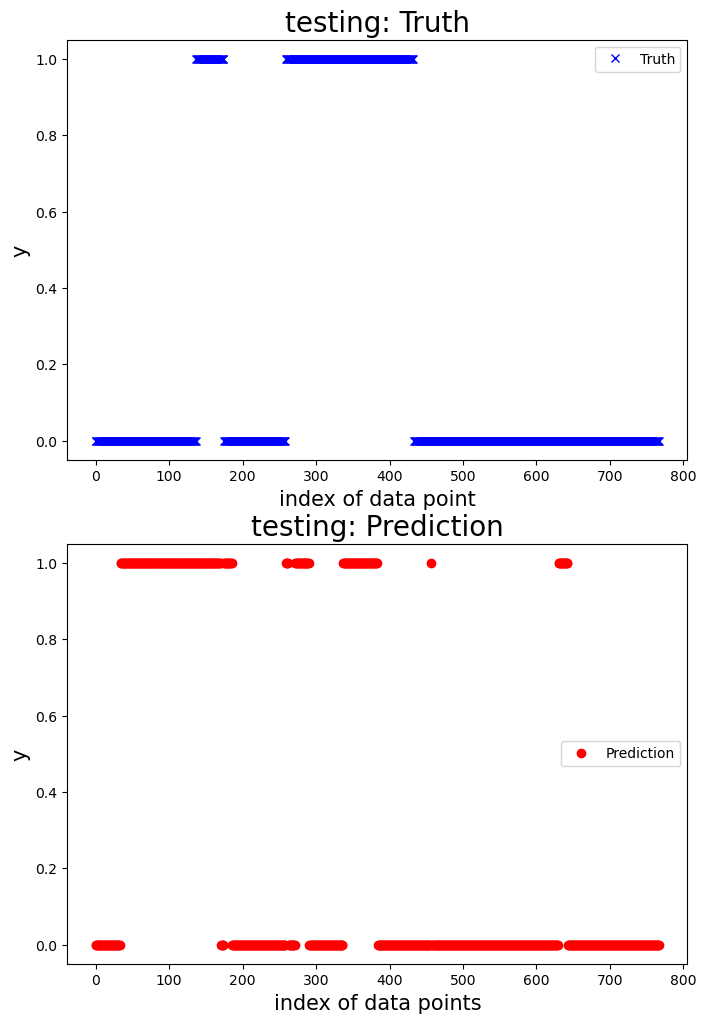

   Accuracy  Precision    Recall  F1 score
0  0.951377   0.877551  0.555735  0.680514
1  0.909910   1.000000  0.756098  0.861111
2  0.927405   1.000000  0.689922  0.816514
3  0.972947   1.000000  0.555556  0.714286
4  0.427193   0.311111  0.726225  0.435609
5  0.815254   0.953545  0.812500  0.877390
6  0.692708   0.448276  0.490566  0.468468


Mean performance metric and standard error:
Accuracy: 0.8138 +- 0.1960
Precision: 0.7986 +- 0.2922
Recall: 0.6552 +- 0.1212
F1 score: 0.6934 +- 0.1802




In [7]:
# Your code here:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from utility import read_all_test_data_from_path, extract_selected_feature, prepare_sliding_window, FaultDetectReg

def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = df['position'] - df['position'].iloc[0]


# Read data.
base_dictionary = '../../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Pre-train the model.
# Get all the normal data.
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213',
    '20240325_152902', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']

df_tr = df_data[df_data['test_condition'].isin(normal_test_id)]

feature_list_all = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

# feature_list_all = ['time', 'data_motor_1_position', 
#                 'data_motor_2_position', 
#                 'data_motor_3_position', 
#                 'data_motor_4_position', 
#                 'data_motor_5_position', 
#                 'data_motor_6_position', 'data_motor_6_temperature']

# Prepare feature and response of the training dataset.
x_tr_org, y_temp_tr_org = extract_selected_feature(df_data=df_tr, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

# Enrich the features based on the sliding window.
window_size = 10
sample_step = 1
prediction_lead_time = 1 
threshold = .9
abnormal_limit = 3

x_tr, y_temp_tr = prepare_sliding_window(df_x=x_tr_org, y=y_temp_tr_org, window_size=window_size, sample_step=sample_step, prediction_lead_time=prediction_lead_time, mdl_type='reg')

# Define the steps of the pipeline
steps = [
    ('standardizer', RobustScaler()),  # Step 1: RobustScaler
    ('regressor', RandomForestRegressor())    # Step 2: Random Forest Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

mdl = mdl_linear_regreession.fit(x_tr, y_temp_tr)

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}



# Test data.
test_id = [
    '20240325_155003',
    '20240425_093699',
    '20240425_094425',
    '20240426_140055',
    '20240503_163963',
    '20240503_164675',
    '20240503_165189'
]
df_test = df_data[df_data['test_condition'].isin(test_id)]

# Define the fault detector.
detector_reg = FaultDetectReg(reg_mdl=mdl_linear_regreession, threshold=threshold, abnormal_limit=abnormal_limit, window_size=window_size, sample_step=sample_step, pred_lead_time=prediction_lead_time)

# # Run cross validation
n_fold = 7
_, y_label_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='clf')
x_test_org, y_temp_test_org = extract_selected_feature(df_data=df_test, feature_list=feature_list_all, motor_idx=6, mdl_type='reg')

motor_idx = 6
print(f'Model for motor {motor_idx}:')
# Run cross validation.
df_perf = detector_reg.run_cross_val(df_x=x_test_org, y_label=y_label_test_org, y_response=y_temp_test_org, 
                                        n_fold=n_fold)
print(df_perf)
print('\n')
# Print the mean performance and standard error.
print('Mean performance metric and standard error:')
for name, metric, error in zip(df_perf.columns, df_perf.mean(), df_perf.std()):
    print(f'{name}: {metric:.4f} +- {error:.4f}') 
print('\n')

The changes made to imrpove the results of the fault detection model include changing StandardScaler to RobustScaler to better handle outliers and replacing Linear Regression with Random Forest Regression for better performance.



## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   91.1%  |   52.2%   |  55.5% | 53.8%|
| Model 2 |   90.9%  |   100.0%   |  75.6% | 86.1%|
| Model 3 |   91.4%  |   100.0%   |  63.6% | 77.7%|
| Model 4 |   97.2%  |   100.0%   |  55.5% | 71.4%|
| Model 5 |   43.1%  |   31.4%   |  73.7% | 44.1%|
| Model 6 |   70.3%  |   46.6%   |  52.3% | 49.3%|

We can see our models performed quite well on the motor which has failure. The accuracy was always close to 90 percent except for model 5. Our F1 score is not really good, so the correlation not perfect. We could train with more data the model, and try out other regression models.